# QuickDraw CNN with Tensorflow 2.0

To start this notebook you need to download the following files. <br>

    - full_numpy_bitmap_airplane.npy
    - full_numpy_bitmap_book.npy
    - full_numpy_bitmap_car.npy
    - full_numpy_bitmap_dog.npy
    - full_numpy_bitmap_face.npy
    - full_numpy_bitmap_apple.npy
    - full_numpy_bitmap_brain.npy
    - full_numpy_bitmap_chair.npy
    - full_numpy_bitmap_eye.npy
    - full_numpy_bitmap_The Eiffel Tower.npy

Then you need to store the file in a folder named: <b>quick_draw_dataset</b>

[Download the files here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1)

# Dependencies

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split #pip install sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os

## Be sure to used Tensorflow 2.0

In [2]:
assert hasattr(tf, "function") # Be sure to use tensorflow 2.0

# Load the dataset

In [3]:
dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)
    
# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)

images.shape (10050, 28, 28)
targets.shape (10050,)
images_valid.shape (4950, 28, 28)
targets_valid.shape (4950,)
['airplane', 'book', 'chair', 'car', 'dog', 'face', 'apple', 'The Eiffel Tower', 'brain', 'eye']


## Plot exemples of images

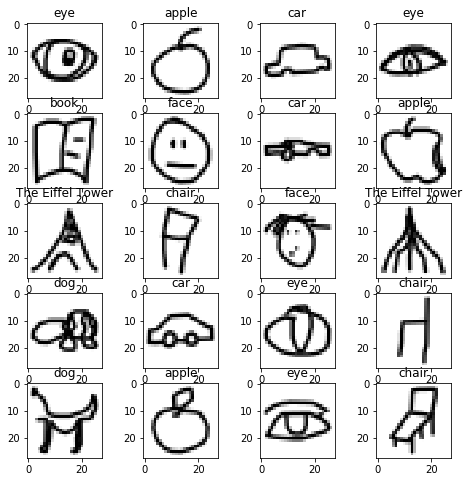

In [4]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])]) 
    plt.imshow(img, cmap="gray")
plt.show()

## Normalization

In [5]:
print("Mean and std of images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Mean and std of scaled images", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Mean and std of images 209.54167 85.16392
Mean and std of scaled images -2.0218012e-09 0.92857134


## Handle dataset
### Create the dataset

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images)
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

### Iter in dataset

In [7]:
for item in train_dataset:
    print(item.shape)
    break

(28, 28, 1)


In [8]:
# Iter in the dataset with a number of epoch and batch size

epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break

(32, 28, 28, 1)


### Create the training dataset

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))

In [10]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break

(32, 28, 28, 1) (32,)


# Build a model with the subclassing API

<img src="./images/cnn.png"></img>

In [11]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(10, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()
model.predict(scaled_images[0:1])

array([[0.11106874, 0.09550468, 0.09348191, 0.09530134, 0.10479427,
        0.08911282, 0.1065027 , 0.10820422, 0.0984744 , 0.09755486]],
      dtype=float32)

## Set the loss and objectives

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

## Set some metrics to track the progress of the training

In [13]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

## Training method
The train_step method used autograp, compute the gradient to optimize the model and gather the loss and accuracy on the training set

In [14]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

## Validation method
The valid_step function is simply used to test the image on the validation set and to gather the loss and accuracy

In [20]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)
    print(predictions)

# Train and test the model on the validation set

In [16]:
epoch = 10
batch_size = 32
b = 0
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 10048/10050, Loss: 0.617580235004425, Accuracy: 80.726364135742194
Epoch 1, Valid Loss: 0.4372346103191376, Valid Accuracy: 86.50505065917969
 Batch 20128/10050, Loss: 0.264153391122818, Accuracy: 91.9601974487304744
Epoch 2, Valid Loss: 0.45975297689437866, Valid Accuracy: 86.7676773071289
 Batch 30208/10050, Loss: 0.13138554990291595, Accuracy: 95.60198974609375
Epoch 3, Valid Loss: 0.5649769306182861, Valid Accuracy: 87.07070922851562
 Batch 40288/10050, Loss: 0.08167523145675659, Accuracy: 97.373130798339841
Epoch 4, Valid Loss: 0.6582668423652649, Valid Accuracy: 86.82828521728516
 Batch 50368/10050, Loss: 0.04857639595866203, Accuracy: 98.368164062553516
Epoch 5, Valid Loss: 0.7418169975280762, Valid Accuracy: 87.35353088378906
 Batch 60448/10050, Loss: 0.02442389540374279, Accuracy: 99.213928222656252
Epoch 6, Valid Loss: 0.8402438163757324, Valid Accuracy: 87.2323226928711
 Batch 70528/10050, Loss: 0.02341713197529316, Accuracy: 99.293533325195315
Epoch 7, Valid Loss: 0.

In [21]:
valid_step(images_batch, targets_batch)

Tensor("conv_model/output/Softmax:0", shape=(22, 10), dtype=float32)


In [48]:
model.predict(scaled_images[5:10])

array([[3.0935828e-22, 3.7046570e-20, 2.4237100e-23, 7.3144389e-20,
        4.7139017e-19, 1.8844725e-15, 6.2699896e-20, 1.0457536e-17,
        4.8133564e-10, 1.0000000e+00],
       [2.4355751e-07, 1.2074955e-09, 9.2156136e-01, 1.4130681e-13,
        5.1278244e-12, 8.9866274e-12, 1.2446504e-08, 7.8438416e-02,
        4.9440011e-08, 9.1324864e-11],
       [1.1993368e-18, 2.9253284e-29, 1.6020626e-20, 1.5120850e-24,
        1.1061976e-24, 1.9036289e-20, 1.6545711e-19, 1.0000000e+00,
        4.2003022e-25, 2.2680771e-21],
       [1.1321800e-16, 1.0000000e+00, 7.0072365e-11, 1.8417055e-13,
        4.2647059e-14, 5.5175742e-13, 3.2252336e-11, 6.3026528e-12,
        1.5537807e-11, 5.9983465e-17],
       [3.6015260e-07, 6.8021053e-15, 3.7094914e-09, 4.6468307e-16,
        9.9999964e-01, 8.0376185e-15, 6.6061796e-12, 1.6946012e-13,
        5.3474758e-10, 9.8485733e-11]], dtype=float32)

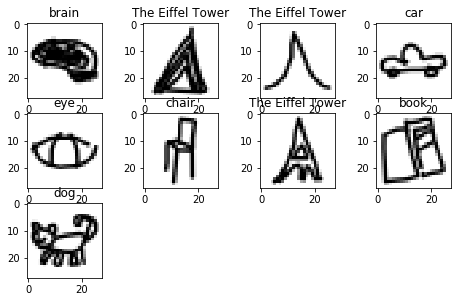

['airplane', 'book', 'chair', 'car', 'dog', 'face', 'apple', 'The Eiffel Tower', 'brain', 'eye']


In [46]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, 10):
    index = np.random.randint(len(images))
    img = images[i]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[i])]) 
    plt.imshow(img, cmap="gray")
plt.show()

print(draw_class)